<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# We are going to import from the local path for models
# Because we are going to add more code 
import importlib
import sys
spec = importlib.util.spec_from_file_location("models", "finrl/agents/stablebaselines3/models.py")
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817780,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300186,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777550,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523602,7325600,CAT,0


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
97008,2023-02-28,482.670013,483.359985,473.920013,468.880890,3902100,UNH,1
97009,2023-02-28,220.000000,221.770004,219.500000,218.634583,5385400,V,1
97010,2023-02-28,38.700001,38.970001,38.549999,36.722885,16685300,VZ,1
97011,2023-02-28,35.480000,35.779999,35.320000,33.584301,8847000,WBA,1
97012,2023-02-28,141.000000,142.649994,140.949997,139.994705,6018000,WMT,1


In [9]:
df.shape

(97013, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817780,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300186,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777550,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523602,7325600,CAT,0


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

tic
AAPL    3311
AMGN    3311
WMT     3311
WBA     3311
VZ      3311
V       3311
UNH     3311
TRV     3311
PG      3311
NKE     3311
MSFT    3311
MRK     3311
MMM     3311
MCD     3311
KO      3311
JPM     3311
JNJ     3311
INTC    3311
IBM     3311
HON     3311
HD      3311
GS      3311
DIS     3311
CVX     3311
CSCO    3311
CRM     3311
CAT     3311
BA      3311
AXP     3311
DOW      994
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [13]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
95839,2023-02-17,182.970001,186.440002,182.509995,181.586121,1155400,TRV,4,-0.729077,188.936965,176.703668,50.470947,-61.694165,10.885409,183.459819,183.182407,18.690267
79110,2020-11-02,34.529999,35.810001,34.369999,30.376881,7448100,WBA,0,-0.367028,32.994383,28.834744,46.387015,-73.638615,9.137005,30.706194,31.582699,25.614773
73369,2020-01-22,115.220001,116.529999,115.180000,109.003960,4926100,WMT,2,-0.890382,113.204864,107.123979,45.725085,-89.062802,24.895338,110.985629,111.157345,33.595455
52102,2017-02-22,183.399994,186.119995,183.080002,145.749222,2850900,MMM,2,1.737199,145.476195,132.930484,67.936291,214.044579,39.696994,138.899328,138.135954,17.872952
16829,2012-04-23,110.519997,111.940002,110.070000,90.300484,7047600,GS,0,-1.537620,104.536972,88.197821,46.029335,-156.035076,25.776492,97.513224,95.303748,50.588564


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = models.DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [20]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.71834260128333
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c\a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 68           |
|    iterations         | 100          |
|    time_elapsed       | 7            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -41.1        |
|    explained_variance | 0.447        |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -21.9        |
|    reward             | -0.014368918 |
|    std                | 0.999        |
|    value_loss         | 0.689        |
----------------------------------------
-------------------------------------
| time/          

---------------------------------------
| time/                 |             |
|    fps                | 62          |
|    iterations         | 1400        |
|    time_elapsed       | 112         |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 0.292       |
|    learning_rate      | 0.0007      |
|    n_updates          | 1399        |
|    policy_loss        | 49.6        |
|    reward             | -0.26370475 |
|    std                | 1.01        |
|    value_loss         | 1.89        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 62         |
|    iterations         | 1500       |
|    time_elapsed       | 120        |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    lear

======PPO Validation from:  2021-10-04 to  2022-01-03
PPO Sharpe Ratio:  0.1234926161285759
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg\ddpg_126_1
day: 2957, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3552433.94
total_reward: 2552433.94
total_cost: 1059.44
total_trades: 53226
Sharpe: 0.741
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 52       |
|    time_elapsed    | 225      |
|    total_timesteps | 11832    |
| train/             |          |
|    actor_loss      | 58.2     |
|    critic_loss     | 6.24e+03 |
|    learning_rate   | 0.0005   |
|    n_updates       | 8874     |
|    reward          | 4.990755 |
---------------------------------
======DDPG Validation from:  2021-10-04 to  2022-01-03
======Best Model Retraining from:  2010-01-01 to  2022-01-03
======Trading from:  2022-01-03 to 

-------------------------------------
| time/                 |           |
|    fps                | 62        |
|    iterations         | 1300      |
|    time_elapsed       | 104       |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1299      |
|    policy_loss        | 11.9      |
|    reward             | 2.9091597 |
|    std                | 1.01      |
|    value_loss         | 1.22      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 62        |
|    iterations         | 1400      |
|    time_elapsed       | 112       |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0.0193    |
|    learning_rate      | 0.0007    |
|    n_updat

======PPO Validation from:  2022-01-03 to  2022-04-04
PPO Sharpe Ratio:  -0.1911575279937626
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg\ddpg_189_1
day: 3020, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5184361.76
total_reward: 4184361.76
total_cost: 1365.04
total_trades: 35934
Sharpe: 0.869
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 52         |
|    time_elapsed    | 232        |
|    total_timesteps | 12084      |
| train/             |            |
|    actor_loss      | -41.2      |
|    critic_loss     | 402        |
|    learning_rate   | 0.0005     |
|    n_updates       | 9063       |
|    reward          | -2.1612184 |
-----------------------------------
======DDPG Validation from:  2022-01-03 to  2022-04-04
======Best Model Retraining from:  2010-01-01 to  2022-04-04
======Tr

--------------------------------------
| time/                 |            |
|    fps                | 61         |
|    iterations         | 1300       |
|    time_elapsed       | 106        |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -41        |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 1299       |
|    policy_loss        | 48         |
|    reward             | 0.51425725 |
|    std                | 0.994      |
|    value_loss         | 1.83       |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 61       |
|    iterations         | 1400     |
|    time_elapsed       | 114      |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -41      |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n

-----------------------------------------
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 5           |
|    time_elapsed         | 154         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.025396373 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.4       |
|    explained_variance   | -0.0434     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.99        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0266     |
|    reward               | -0.6961401  |
|    std                  | 1.01        |
|    value_loss           | 9.99        |
-----------------------------------------
======PPO Validation from:  2022-04-04 to  2022-07-06
PPO Sharpe Ratio:  -0.26459557102627085
======DDPG Training========
{'buffer_size': 10000, 'learning_rate'

-------------------------------------
| time/                 |           |
|    fps                | 63        |
|    iterations         | 1100      |
|    time_elapsed       | 86        |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1099      |
|    policy_loss        | 20.1      |
|    reward             | 2.4278088 |
|    std                | 1         |
|    value_loss         | 0.847     |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 63         |
|    iterations         | 1200       |
|    time_elapsed       | 94         |
|    total_timesteps    | 6000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

------------------------------------------
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 4            |
|    time_elapsed         | 123          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0140646435 |
|    clip_fraction        | 0.147        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.000556     |
|    learning_rate        | 0.00025      |
|    loss                 | 29.9         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0208      |
|    reward               | 1.0106975    |
|    std                  | 1            |
|    value_loss           | 85.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 66          |
|    iteration

In [21]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.379193,0.123493,0.180426
1,189,2022-01-03,2022-04-04,A2C,-0.133847,-0.191158,-0.160634
2,252,2022-04-04,2022-07-06,A2C,-0.137346,-0.264596,-0.190062
3,315,2022-07-06,2022-10-04,DDPG,-0.1365,-0.188222,-0.09517


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [23]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.32834148835650745


In [24]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999242.845010,2022-01-04,-0.000757,2022-01-04
2,997930.195745,2022-01-05,-0.001314,2022-01-05
3,991923.049317,2022-01-06,-0.006020,2022-01-06
4,985731.910500,2022-01-07,-0.006242,2022-01-07


<Axes: >

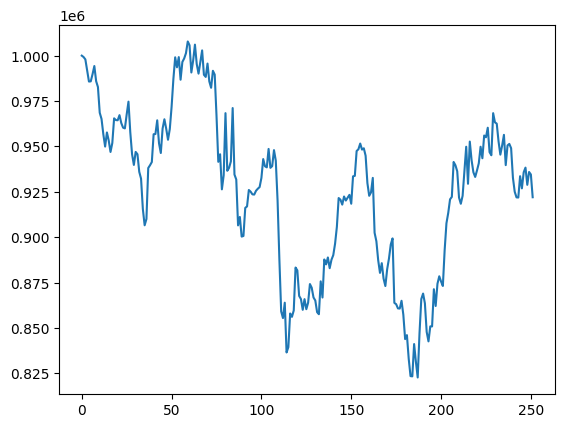

In [25]:
%matplotlib inline
df_account_value.account_value.plot()

In [26]:
df_account_value_averageaction=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('averageaction',i))
    df_account_value_averageaction = pd.concat([df_account_value_averageaction,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value_averageaction.account_value.pct_change(1).mean()/df_account_value_averageaction.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_averageaction=df_account_value_averageaction.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.019834530062985953


In [27]:
df_account_value_averageaction.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999468.815768,2022-01-04,-0.000531,2022-01-04
2,995527.386194,2022-01-05,-0.003944,2022-01-05
3,994876.474678,2022-01-06,-0.000654,2022-01-06
4,995568.046924,2022-01-07,0.000695,2022-01-07


<Axes: >

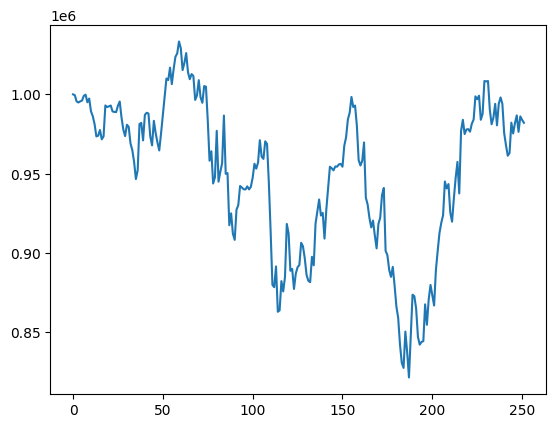

In [28]:
%matplotlib inline
df_account_value_averageaction.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("---------------------------------------------")
perf_stats_all_ = backtest_stats(account_value=df_account_value_averageaction)
perf_stats_all_ = pd.DataFrame(perf_stats_all_)

==============Get Backtest Results===========
Annual return         -0.078003
Cumulative returns    -0.078003
Annual volatility      0.192163
Sharpe ratio          -0.328341
Calmar ratio          -0.424674
Stability              0.189601
Max drawdown          -0.183677
Omega ratio            0.945436
Sortino ratio         -0.449768
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.103541
Daily value at risk   -0.024461
dtype: float64
---------------------------------------------
Annual return         -0.017937
Cumulative returns    -0.017937
Annual volatility      0.211846
Sharpe ratio           0.019835
Calmar ratio          -0.087456
Stability              0.117771
Max drawdown          -0.205096
Omega ratio            1.003420
Sortino ratio          0.027912
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003602
Daily value at risk   -0.026673
dtype: float64


In [30]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [31]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')
df_account_value_averageaction.to_csv('df_account_value_averageaction.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_result_averageaction.columns:  Index(['averageaction'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                    ensemble
date                      
2022-01-03  1000000.000000
2022-01-04   999242.845010
2022-01-05   997930.195745
2022-01-06   991923.049317
2022-01-07   985731.910500
...                    ...
2022-12-27   938312.163434
2022-12-28   928832.835316
2022-12-29   935909.689347
2022-12-30   934517.631207
2023-01-03   921996.941754

[252 rows x 1 columns]
df_result_averageaction:               averageaction
date                      
2022-01-03  1000000.000000
2022-01-04   999468.815768
2022-01-05   995527.386194
2022-01-06   994876.474678
2022-01-07   995568.046924
...              

<Figure size 1500x500 with 0 Axes>

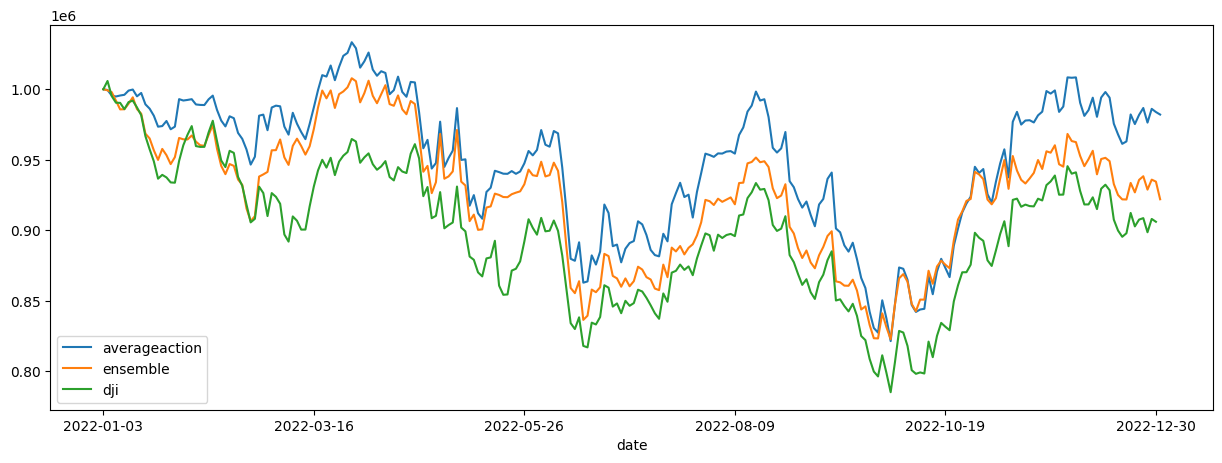

In [32]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_averageaction = pd.DataFrame({'date': df_account_value_averageaction['date'], 
                                        'averageaction': df_account_value_averageaction['account_value']})
df_result_averageaction = df_result_averageaction.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_result_averageaction.columns: ", df_result_averageaction.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
df_result_averageaction.to_csv("df_result_averageaction.csv")
print("df_result_averageaction: ", df_result_averageaction)

print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_averageaction, result, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['averageaction', 'ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();